# Model NEATM 余亮亮 修改 $\alpha, \phi$
$D_{eff}=\frac{1329\times10^{-H_v/5}}{\sqrt{p_v}}$
$p_v=\frac{A_B}{q}$
$q_s=\frac{F_{sun}}{d^2}$
$T_{fit}=[\frac{(1-A)F_{sun}}{\eta\epsilon\sigma d}]^{1/4}$
$T=T(\theta,\phi)=T_{fit}\cos^{1/4}\theta\cos^{1/4}\phi,(-\frac{\pi}{2}<\theta<\frac{\pi}{2},-\frac{\pi}{2}<\phi<\frac{\pi}{2})$
$F_\lambda=F(\Delta,d,\alpha|\eta,D)$

$F_\lambda=\frac{\epsilon D^2}{2\Delta ^2}\frac{\pi h c^2}{\lambda ^5}\int_{-\pi/2}^{\pi/2}d\phi\int_{\alpha-\pi/2}^{\pi/2}\frac{1}{exp(\frac{hc}{\lambda kT(\theta,\phi)}-1)}\cos^2 \phi\cos(\alpha-\theta)d\theta$


# MCMC_NEATM

## define const & import

In [18]:
#import
import numpy as np
import matplotlib.pyplot as plt
import math as mh 
import pandas as pd
from tqdm import tqdm
import os
#constant
Fsun = 1367.5  
Fsun = 1.3608e3# sun constant
sigma = 5.67E-8         #stefan-boltzmann constant
h = 6.626007004E-34     #plank constant
#q = 0.29+0.684*0.15    #phase integral = 0.29+0.684*G(=0.15)
epsi = 0.9              #radiance epsilon
kB = 1.38064852E-23     #boltzmann constant  j/k
cl = 299792458.0        #lightspeed m/s
au = 149597870700.0
pi = 3.1415926535
eta_guess = [1.2,0.7]
D_guess = [400,200000]
logf_guess = [1,0.1,1]
eta_piror = [0.5,2.8]
D_piror = [0,2500000]
Hv = 21.4
G = 0.15
Ndd = 15
lamdai = [3.4,4.6,12,22]

## define MODEL FUNCTION
initial x:flux = delta, it will change "delta"!
list: a,b
a = b
a = b[:]

## jhx

In [19]:
#constants---------------------------------------------------------------------------
#emissivity:
epsi = 0.9
#stefan-boltzman:
sigmas = 5.67*10**(-8)
#solar constant:
f_solar = 1367.5
#planck constant:
h = 6.62607015 * 10 ** (-34)
#speed of light
c = 3.0 * 10 ** 8 
#boltzmann constant
kb = 1.380649 * 10 ** (-23)
#astronomical unit in unit of meter
au = 1.496 * 10 ** 11
def neatm_jhx(Ndd,dast,dao,alpha,Dia,wlenth,yita,A,elamda):
    #dast: distance from asteroid to Sun :d
    #dobs: distance from observer to Sun  :dd
    #dao:  distance from asteroid to observer :delta
    #alpha: solar phase
    #dia: diameter of asteroid
    #wlenth: wavelength
    #yita: beaming parameter
    #A: bond albedo
	
	T_ss = ((1 - A) * f_solar / epsi / yita / sigmas / dast ** 2) ** 0.25
	Nd = int(Ndd)
	phi = np.zeros((Nd-1,1))
	theta = np.zeros((Nd-1,1))
	for i in range(0,Nd-1):#phi , theta is the angle from subsolar point
			phi[i] = -pi/2.0 + i * pi / Nd
			theta[i] = -pi/2.0 + i * pi / Nd
	nj = np.floor(((alpha - pi / 2.0) + pi / 2.0) / (pi / Nd)) 
	dphi, dtheta = pi/Nd,pi/Nd
	ss = dphi*dtheta#dtheta*dphi
	wlenth = wlenth * 10 ** (-6)
	temp = np.zeros((len(phi),len(theta)))
	flux = 0.0
	flux_con = epsi * Dia ** 2 * pi  * h * c ** 2  / (wlenth ** 5)
	for j in range(0,len(phi)):
		for k in range(int(nj),len(theta)):
			temp[j,k] = T_ss * np.cos(theta[k]) ** 0.25 * np.cos(phi[j]) ** 0.25
			flux = flux + flux_con * abs(np.cos(phi[j]) ** 2) * abs(np.cos(alpha - theta[k])) / (2 * (dao * au) ** 2) / (np.exp(h * c / (wlenth * kb * temp[j,k])) - 1) * ss * wlenth ** 2 / c * 10 ** 29 # obtain flux in unit of mjy
	return flux*elamda
def Model_neatm_jhx(theta,x,lamda):
    eta,D,e12 =theta
    delta,d,alpha = x
    lamda1,lamda2,lamda3,lamda4 = lamda
    pv = (1329*pow(10,-Hv/5)/(D*0.001))**2
    q = 0.29+0.684*G
    A = q*pv
    nn = len(delta)
    flux = np.zeros(nn)
    for i in range(0,int(nn/4)):
        fluxi = neatm_jhx(Ndd,d[i],delta[i],alpha[i],D,lamda1,eta,A,e12)
        if fluxi!=fluxi:fluxi = 0
        flux[i] = fluxi
    for i in range(int(nn/4),int(nn/2)):
        fluxi = neatm_jhx(Ndd,d[i],delta[i],alpha[i],D,lamda2,eta,A,e12)
        if fluxi!=fluxi:fluxi = 0
        flux[i] = fluxi
    for i in range(int(nn/2),int(nn*3/4)):
        fluxi = neatm_jhx(Ndd,d[i],delta[i],alpha[i],D,lamda3,eta,A,1.0)
        if fluxi!=fluxi:fluxi = 0
        flux[i] = fluxi
    for i in range(int(nn*3/4),nn):
        fluxi = neatm_jhx(Ndd,d[i],delta[i],alpha[i],D,lamda4,eta,A,1.0)
        if fluxi!=fluxi:fluxi = 0
        flux[i] = fluxi   
    #print('hello',flux)
    return flux

In [20]:
#n = 56
#print(0,int(n/4),int(n/2),int(n/4*3),n)

## read data file

处理原始数据 将坐标垂直叠加，方便直接计算12，22微米的流量

In [21]:
namelist = ['2003MA3','2010CO1','2010DG77','2010EX11','2010FC81','2010FH81','2010GS7','2010JN71','2010KX7','2010PW58','2010XP69','2019DD2']
name = namelist[4].lower()
name = '2010jn71'
name

'2010jn71'

计算delta d 看看对不对

In [22]:
obsec = np.loadtxt(f'w1234newepoch_{name}.txt')
#print(obsec)
d_N = np.sqrt(obsec[:,0]**2+obsec[:,1]**2+obsec[:,2]**2)
delta_N = np.sqrt((obsec[:,3]-obsec[:,0])**2+(obsec[:,4]-obsec[:,1])**2+(obsec[:,5]-obsec[:,2])**2)
#earth-sun
print(delta_N)
dd_N = np.sqrt(obsec[:,3]**2+obsec[:,4]**2+obsec[:,5]**2)
alpha_N = (delta_N*delta_N+d_N*d_N-dd_N*dd_N)/(2*delta_N*d_N)
alpha_N = np.arccos(alpha_N)
alpha_N/pi*180

[0.10626916 0.10532268 0.10437609 0.10390322 0.10342941 0.10248265
 0.10200971 0.10106286 0.16815758 0.16907279 0.16952969 0.17135731
 0.17181333 0.17363738 0.10626916 0.10532268 0.10437609 0.10390322
 0.10342941 0.10248265 0.10200971 0.10106286 0.16815758 0.16907279
 0.16952969 0.17135731 0.17181333 0.17363738 0.10626916 0.10532268
 0.10437609 0.10390322 0.10342941 0.10248265 0.10200971 0.10106286
 0.16815758 0.16907279 0.16952969 0.17135731 0.17181333 0.17363738
 0.10626916 0.10532268 0.10437609 0.10390322 0.10342941 0.10248265
 0.10200971 0.10106286 0.16815758 0.16907279 0.16952969 0.17135731
 0.17181333 0.17363738]


array([80.09450103, 80.28108659, 80.46908073, 80.56352448, 80.65851707,
       80.84943477, 80.94536824, 81.13858114, 80.73849343, 80.59860584,
       80.52886814, 80.25055746, 80.1812716 , 79.90474298, 80.09450103,
       80.28108659, 80.46908073, 80.56352448, 80.65851707, 80.84943477,
       80.94536824, 81.13858114, 80.73849343, 80.59860584, 80.52886814,
       80.25055746, 80.1812716 , 79.90474298, 80.09450103, 80.28108659,
       80.46908073, 80.56352448, 80.65851707, 80.84943477, 80.94536824,
       81.13858114, 80.73849343, 80.59860584, 80.52886814, 80.25055746,
       80.1812716 , 79.90474298, 80.09450103, 80.28108659, 80.46908073,
       80.56352448, 80.65851707, 80.84943477, 80.94536824, 81.13858114,
       80.73849343, 80.59860584, 80.52886814, 80.25055746, 80.1812716 ,
       79.90474298])

[1.86467694e-02 1.89374367e-02 1.92340736e-02 1.93845288e-02
 1.95368249e-02 1.98458458e-02 2.00026036e-02 2.03213207e-02
 7.14240048e-03 7.07297468e-03 7.03860426e-03 6.90301439e-03
 6.86964779e-03 6.73800176e-03 2.39276178e-01 2.42955188e-01
 2.46712006e-01 2.48618354e-01 2.50548635e-01 2.54467221e-01
 2.56455989e-01 2.60501571e-01 9.23541480e-02 9.14884162e-02
 9.10599789e-02 8.93708189e-02 8.89553859e-02 8.73172407e-02
 1.67814208e+01 1.70350825e+01 1.72944273e+01 1.74261521e+01
 1.75596159e+01 1.78308207e+01 1.79685997e+01 1.82491573e+01
 6.56813402e+00 6.51003665e+00 6.48130876e+00 6.36819764e+00
 6.34041598e+00 6.23100820e+00 1.82277043e+01 1.85023144e+01
 1.87831731e+01 1.89258624e+01 1.90704610e+01 1.93643717e+01
 1.95137268e+01 1.98179417e+01 7.16109193e+00 7.09865706e+00
 7.06779185e+00 6.94631386e+00 6.91648904e+00 6.79908073e+00]


/tmp/ipykernel_1352237/3310534899.py:43: RuntimeWarning: overflow encountered in exp
  flux = flux + flux_con * abs(np.cos(phi[j]) ** 2) * abs(np.cos(alpha - theta[k])) / (2 * (dao * au) ** 2) / (np.exp(h * c / (wlenth * kb * temp[j,k])) - 1) * ss * wlenth ** 2 / c * 10 ** 29 # obtain flux in unit of mjy


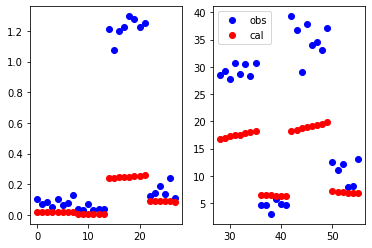

In [23]:

obsec = np.loadtxt(f'w1234newepoch_{name}.txt')
obsdat = np.loadtxt(f'w1234_{name}.txt')


#ast-sun
d_N = np.sqrt(obsec[:,0]**2+obsec[:,1]**2+obsec[:,2]**2)
#print('ast-sun',d_N)

#ast-earth
delta_N = np.sqrt((obsec[:,3]-obsec[:,0])**2+(obsec[:,4]-obsec[:,1])**2+(obsec[:,5]-obsec[:,2])**2)
#print('ast-earth',delta_N)

#earth-sun
dd_N = np.sqrt(obsec[:,3]**2+obsec[:,4]**2+obsec[:,5]**2)
#print('earth-sun',dd_N)

#alpha
alpha_N = (delta_N*delta_N+d_N*d_N-dd_N*dd_N)/(2*delta_N*d_N)
alpha_N = np.arccos(alpha_N)
#print("alpha",alpha_N/pi*180,'\n')
y = obsdat
leny  = len(y)
nt = np.arange(len(d_N))
theta = [1.5,100,0.4]
flux = Model_neatm_jhx(theta,x=(delta_N,d_N,alpha_N),lamda=lamdai)
x = (delta_N,d_N,alpha_N)
yerr = 0.1*y
#plt.plot(nt,flux,label = 'hhq')
#plt.plot(nt,flux,label = 'hhq')
##
plt.subplot(1,2,1)
plt.plot(nt[0:int(leny/2)],obsdat[0:int(leny/2)],'bo',label = 'obs')
plt.plot(nt[0:int(leny/2)],flux[0:int(leny/2)],'ro',label = 'cal')
plt.subplot(1,2,2)
plt.plot(nt[int(leny/2):leny],obsdat[int(leny/2):leny],'bo',label = 'obs')
plt.plot(nt[int(leny/2):leny],flux[int(leny/2):leny],'ro',label = 'cal')
print(flux)
#plt.plot(nt[0:len(d_N)],alpha_N[0:len(d_N)],'go',label = 'alpha')
#print(flux[0:len(d_N)])
plt.legend()

/tmp/ipykernel_1352237/3310534899.py:43: RuntimeWarning: overflow encountered in exp
  flux = flux + flux_con * abs(np.cos(phi[j]) ** 2) * abs(np.cos(alpha - theta[k])) / (2 * (dao * au) ** 2) / (np.exp(h * c / (wlenth * kb * temp[j,k])) - 1) * ss * wlenth ** 2 / c * 10 ** 29 # obtain flux in unit of mjy


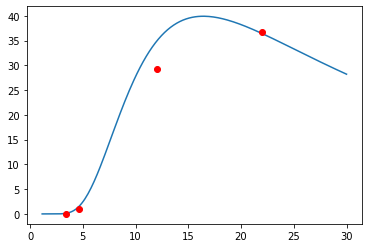

In [46]:

lenthi = [1,30,200]
dddd = (lenthi[1]-lenthi[0])/lenthi[2]
lenth = lenthi[0]
D = 136
pv = (1329*pow(10,-Hv/5)/(D*0.001))**2
q = 0.29+0.684*G
A = q*pv
flamda = []
nlenth  = []
numi = 1
for i in range(lenthi[2]):
    lenth = lenth+dddd
    nlenth.append(lenth)
    flamda.append((neatm_jhx(Ndd,d_N[numi],delta_N[numi],alpha_N[numi],D,lenth,1.5,A,1)))
plt.plot(nlenth,flamda,label = 'cal') 
ylamda = [y[numi],y[numi+int(leny/4)],y[numi+int(leny/4*2)],y[numi+int(leny/4*3)]] 
plt.plot(lamdai,ylamda,'ro')

## define MCMC_function

In [25]:
#initial
eta_gs = 1.2
D_gs = 150
e12_gs = 1
e34_gs  = 1
eta_gss = [0.5,10]
D_gss = [1,300]
e12_gss = [0,1.2]
e34_gss = [0,1.2]


In [26]:
#MCMC Function
def log_likelihood(theta, x, y, yerr):
    eta,D,e12= theta
    model = Model_neatm_jhx(theta,x,lamdai)
    #model = eta*x[0]*100 + D
    sigma2 = yerr ** 2
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))
def log_prior(theta):
    eta,D,e12= theta
    if eta_gss[0]< eta < eta_gss[1] and D_gss[0] < D < D_gss[1] and e12_gss[0]< e12 < e12_gss[1]:
        return 0.0
    return -np.inf
    #return 0
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
     #   print('hi','-inf')
        return -np.inf
    yy=lp + log_likelihood(theta, x, y, yerr)
    #print('hi',yy)
    return yy


In [27]:
#initial para guesses
eta = eta_gs
D = D_gs
e12 = e12_gs
e34 = e34_gs
theta = [eta, D,e12]

In [28]:
import emcee
#initialize sampler
ndim, nwalkers = len(theta), 8
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr))
pos = [theta + 1e-6*np.random.randn(ndim) for i in range(nwalkers)]
#run mcmc
sampler.run_mcmc(pos, 1000, progress=True);

/tmp/ipykernel_1352237/3310534899.py:43: RuntimeWarning: overflow encountered in exp
  flux = flux + flux_con * abs(np.cos(phi[j]) ** 2) * abs(np.cos(alpha - theta[k])) / (2 * (dao * au) ** 2) / (np.exp(h * c / (wlenth * kb * temp[j,k])) - 1) * ss * wlenth ** 2 / c * 10 ** 29 # obtain flux in unit of mjy
100%|██████████| 1000/1000 [12:34<00:00,  1.33it/s]


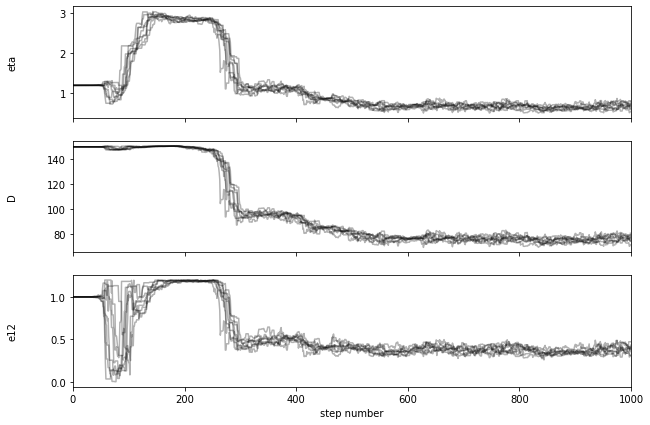

In [33]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["eta", "D","e12"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    axes[-1].set_xlabel("step number");

(208, 3)


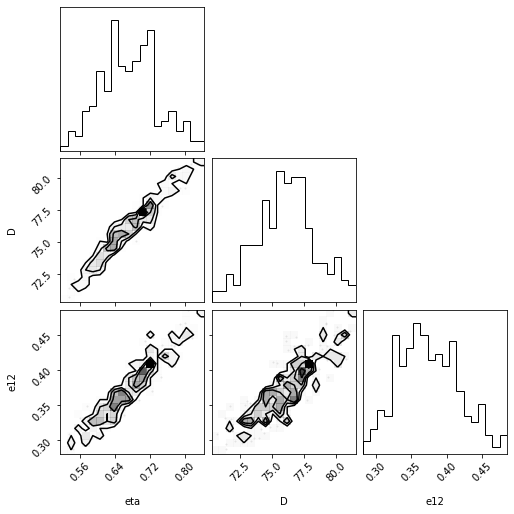

In [30]:
#--------------------------
flat_samples = sampler.get_chain(discard=600, thin=15, flat=True)
print(flat_samples.shape)
import corner
fig = corner.corner(
flat_samples, labels=labels, truths=[eta_gs, D_gs,e12_gs]
);

## Truth 0.214

In [31]:
from IPython.display import display, Math
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    #print(mcmc[1],q[0],q[1],labels[i])
    display(Math(txt))
print(Math(txt))
D_low,D_fit,D_high = np.percentile(flat_samples[:, 1], [16, 50, 84])
pv = (1329*pow(10,-Hv/5)/(D_fit*0.001))**2
print('eta_gs = ',eta_gs,'D_gs= ',D_gs,'pv=',pv)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>
eta_gs =  1.2 D_gs=  150 pv= 0.8398297162815643


eta_fit =  0.6725235449686773 D_fit=  76.10783398628945 pv =  0.8398297162815643
loss =  72.54083310702994


/tmp/ipykernel_1352237/3310534899.py:43: RuntimeWarning: overflow encountered in exp
  flux = flux + flux_con * abs(np.cos(phi[j]) ** 2) * abs(np.cos(alpha - theta[k])) / (2 * (dao * au) ** 2) / (np.exp(h * c / (wlenth * kb * temp[j,k])) - 1) * ss * wlenth ** 2 / c * 10 ** 29 # obtain flux in unit of mjy
/tmp/ipykernel_1352237/3310534899.py:43: RuntimeWarning: overflow encountered in exp
  flux = flux + flux_con * abs(np.cos(phi[j]) ** 2) * abs(np.cos(alpha - theta[k])) / (2 * (dao * au) ** 2) / (np.exp(h * c / (wlenth * kb * temp[j,k])) - 1) * ss * wlenth ** 2 / c * 10 ** 29 # obtain flux in unit of mjy
/tmp/ipykernel_1352237/3310534899.py:43: RuntimeWarning: overflow encountered in exp
  flux = flux + flux_con * abs(np.cos(phi[j]) ** 2) * abs(np.cos(alpha - theta[k])) / (2 * (dao * au) ** 2) / (np.exp(h * c / (wlenth * kb * temp[j,k])) - 1) * ss * wlenth ** 2 / c * 10 ** 29 # obtain flux in unit of mjy
/tmp/ipykernel_1352237/3310534899.py:43: RuntimeWarning: overflow encountered in e

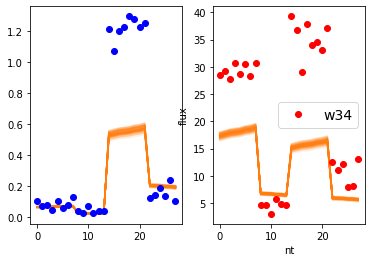

In [38]:
def loss(cal,y,yerr):
    nn = len(y)
    return sum(((cal-y)/yerr)**2)/nn
eta_low,eta_fit,eta_high = np.percentile(flat_samples[:, 0], [16, 50, 84])
D_low,D_fit,D_high = np.percentile(flat_samples[:, 1], [16, 50, 84])
e12_low,e12_fit,e12_high = np.percentile(flat_samples[:, 2], [16, 50, 84])
#e34_low,e34_fit,e34_high = np.percentile(flat_samples[:, 3], [16, 50, 84])
print('eta_fit = ',eta_fit,'D_fit= ',D_fit,'pv = ',(1329*pow(10,-Hv/5)/(D_fit*0.001))**2)
theta = eta_fit,D_fit,e12_fit

leni = len(nt)
half = int(leni/2)
yt = Model_neatm_jhx(theta,x,lamdai)
print('loss = ',loss(yt,y,yt*0.1))
plt.plot(nt[0:half], yt[0:half],"k")
plt.plot(nt[0:half], yt[half:leni],"k", label="Most")

inds = np.random.randint(len(flat_samples), size=100)
#print(nt)
#print(len(flat_samples))

#print(nt[0:half])
#print(nt[half:leni])
for ind in inds:
    sample = flat_samples[ind]
    #print(ind,':',sample)
    plotmodel = Model_neatm_jhx(sample,x,lamdai)
    plt.subplot(1,2,1)
    plt.plot(nt[0:half], plotmodel[0:half], "C1", alpha=0.1)
    plt.subplot(1,2,2)
    plt.plot(nt[0:half], plotmodel[half:leni], "C1", alpha=0.1)
plt.subplot(1,2,1)
plt.plot(nt[0:half],y[0:half],'bo',label = 'w12')
plt.subplot(1,2,2)
plt.plot(nt[0:half],y[half:leni],'ro',label = 'w34')
#plt.errorbar(nt[0:half], y[0:half], yerr=yerr[0:half], fmt=".k", capsize=0)
#plt.errorbar(nt[0:half], y[half:leni], yerr=yerr[half:leni], fmt=".k", capsize=0)
plt.legend(fontsize=14)
plt.xlabel("nt")
plt.ylabel("flux");
